In [1]:
import japanize_matplotlib
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from full_fred.fred import Fred

# FRED_API_KEY = os.getenv('FRED_API_KEY')
fred = Fred()
print(f"FRED APIキーが環境変数に設定されている：{fred.env_api_key_found()}")


def get_fred_data(name, start="2013-01-01", end=""):
    df = fred.get_series_df(name)[["date", "value"]].copy()
    df["date"] = pd.to_datetime(df["date"])
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    df = df.set_index("date")

    if end == "":
        df = df.loc[f"{start}":]
    else:
        df = df.loc[f"{start}":f"{end}"]

    return df

FRED APIキーが環境変数に設定されている：True


## Producer Price Index by Commodity: Metals and Metal Products: Iron and Steel 
ソース： https://fred.stlouisfed.org/series/WPU101

鉄及び鋼の生産者物価指数

In [2]:
df_WPU101 = get_fred_data("WPU101", start="2018-01-01", end="2022-05-01")
df_WPU101.head(5)

,value
date,
2018-01-01,217.6
2018-02-01,222.1
2018-03-01,227.5
2018-04-01,234.1
2018-05-01,239.0


<AxesSubplot:xlabel='date', ylabel='value'>

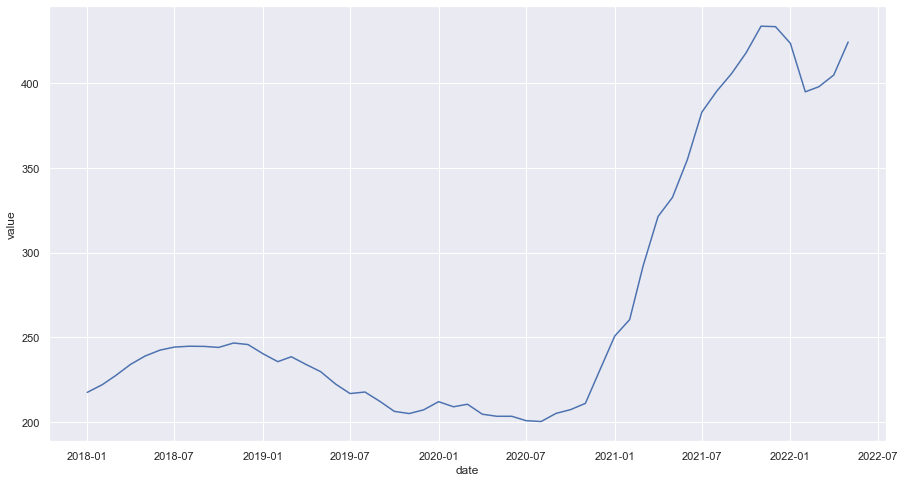

In [3]:
sns.set(rc={"figure.figsize": (15, 8)})
sns.lineplot(data=df_WPU101, x="date", y="value")

## GNKの価格推移
[Genco Shipping & Trading Limited (＄GNK)](https://www.gencoshipping.com/)の株価と上記グラフを比較してみます。

In [4]:
df_GNK = pd.read_csv("./GNK.csv")
df_GNK["Date"] = pd.to_datetime(df_GNK["Date"])
df_GNK = df_GNK.set_index("Date").resample("M").mean()
df_GNK.index = df_GNK.index + pd.DateOffset(1)  # 日付を月初に調整する
df_GNK = df_GNK.loc["2018-01-01":"2022-05-01"]
df_GNK.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,12.5575,13.4355,12.1375,12.7650,11.157512,603175.0
2018-02-01,13.9720,14.5420,13.1310,13.7600,12.027212,510600.0
2018-03-01,12.9925,13.8525,12.6520,13.4300,11.738769,357050.0
2018-04-01,15.0100,15.6925,14.4025,14.7575,12.899099,796075.0
2018-05-01,15.5280,16.3530,14.9620,15.9580,13.948420,631500.0


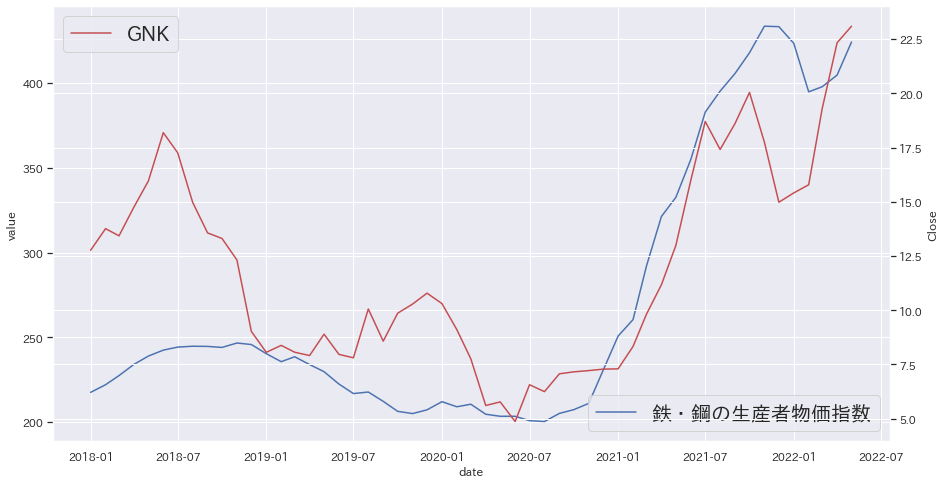

In [5]:
japanize_matplotlib.japanize()

fig = plt.figure()
ax1 = fig.add_subplot(111)
sns.lineplot(data=df_WPU101, x="date", y="value", label="鉄・鋼の生産者物価指数")
plt.legend(loc="lower right", fontsize="20")

ax2 = ax1.twinx()
sns.lineplot(data=df_GNK, x="Date", y="Close", label="GNK", color="r")
plt.legend(loc="upper left", fontsize="20")

## 相互相関を求める
> [相互相関関数](https://ja.wikipedia.org/wiki/%E7%9B%B8%E4%BA%92%E7%9B%B8%E9%96%A2%E9%96%A2%E6%95%B0)は、ふたつの信号、配列（ベクトル）の類似性を確認するために使われる。関数の配列の結果がすべて1であれば相関があり、すべてゼロであれば無相関であり、すべて −1 であれば負の相関がある。しばしば、相関と略されることがあり、相関係数と似ているために混同することがある。 (出典：Wikipedia)

ドキュメント： [numpy.correlate](https://numpy.org/doc/stable/reference/generated/numpy.correlate.html)

ラグ： 0


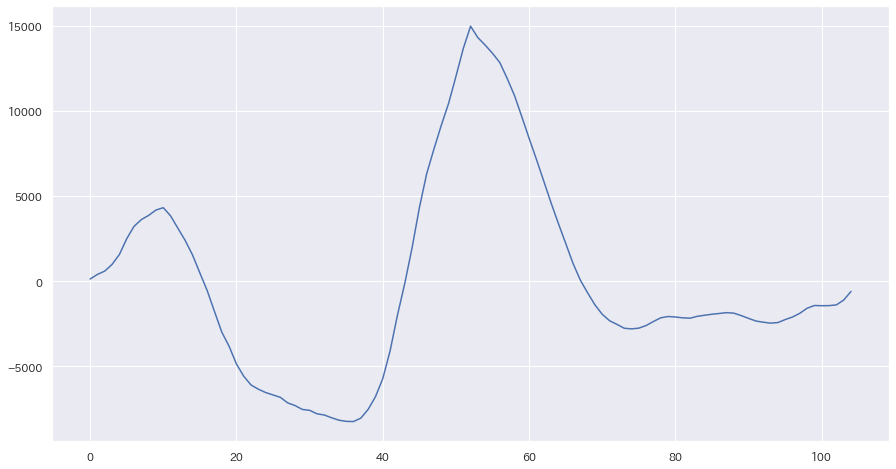

In [6]:
df_GNK["Close_norm"] = df_GNK["Close"] - df_GNK["Close"].mean()
df_WPU101["value_norm"] = df_WPU101["value"] - df_WPU101["value"].mean()

corr = np.correlate(df_GNK["Close_norm"], df_WPU101["value_norm"], "full")
delay = corr.argmax() - (len(df_WPU101["value_norm"]) - 1)
print("ラグ： " + str(delay))

plt.plot(corr)

## Producer Price Index by Industry: Iron Ore Mining
ソース：https://fred.stlouisfed.org/series/PCU2122121221

鉄鉱石の生産者物価指数

In [7]:
df_PCU2122121221 = get_fred_data("PCU2122121221", start="2018-01-01", end="2022-05-01")
df_PCU2122121221.head(5)

,value
date,
2018-01-01,121.0
2018-02-01,122.5
2018-03-01,122.5
2018-04-01,133.8
2018-05-01,138.7


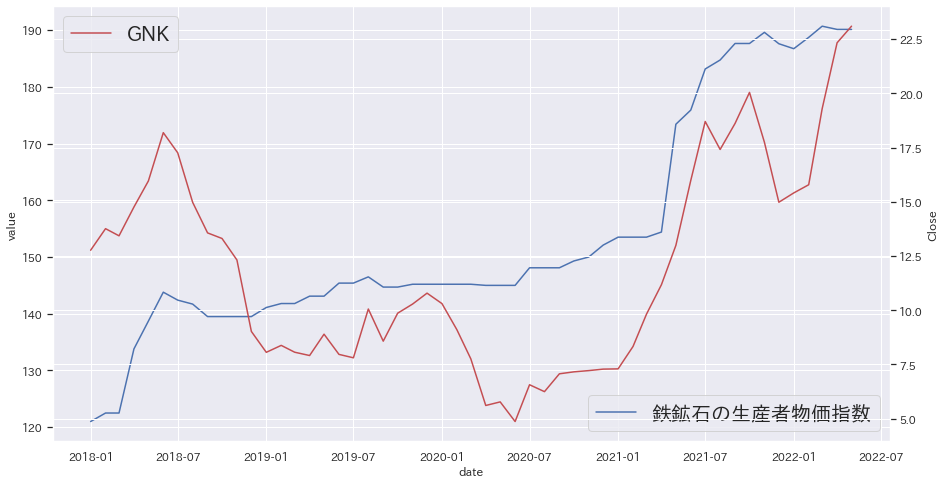

In [8]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
sns.lineplot(data=df_PCU2122121221, x="date", y="value", label="鉄鉱石の生産者物価指数")
plt.legend(loc="lower right", fontsize="20")

ax2 = ax1.twinx()
sns.lineplot(data=df_GNK, x="Date", y="Close", label="GNK", color="r")
plt.legend(loc="upper left", fontsize="20")

ラグ： 0


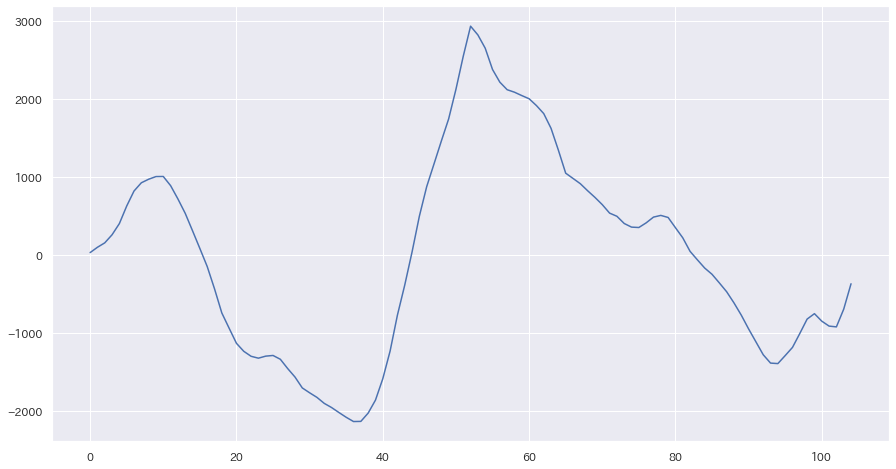

In [9]:
df_PCU2122121221["value_norm"] = (
    df_PCU2122121221["value"] - df_PCU2122121221["value"].mean()
)

corr = np.correlate(df_GNK["Close_norm"], df_PCU2122121221["value_norm"], "full")
delay = corr.argmax() - (len(df_PCU2122121221["value_norm"]) - 1)
print("ラグ： " + str(delay))

plt.plot(corr)